# CIFAR10 Classification w/ Conv2D Layers
- Data Home: https://www.cs.toronto.edu/~kriz/cifar.html

## Study Objective
- A little bit up to somewhere in https://www.kaggle.com/c/cifar-10/leaderboard

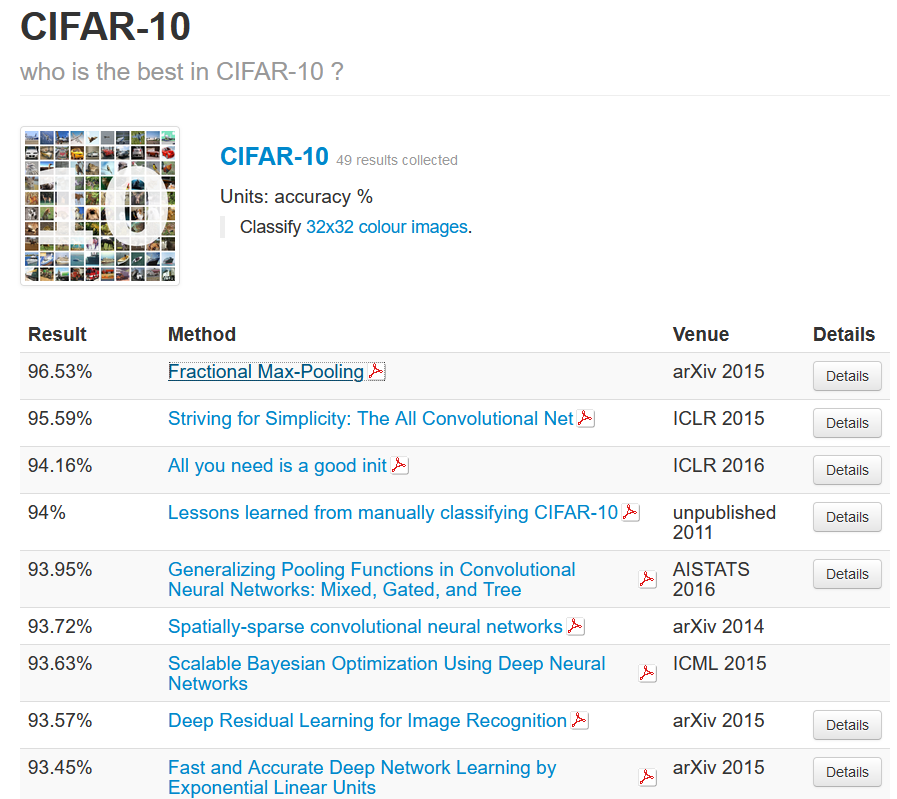

## Getting the Data

![CIFAR10](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import time

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
tvset = ['train', 'val']
dataset = {'train': torchvision.datasets.CIFAR10('../data', train=True, download=True),
              'val' : torchvision.datasets.CIFAR10('../data', train=False, download=True) }

class_names = ['airplane', 'automobile' , 'bird' , 'cat' ,  'deer' ,  'dog' ,  'frog' ,  'horse' ,  'ship' , 'truck']

Files already downloaded and verified
Files already downloaded and verified


### torchvision datasets are of type PIL

In [3]:
im, label = dataset['train'][0]
im, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x140B990D088>, 6, 'frog')

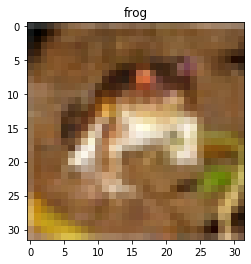

In [4]:
plt.imshow(im, cmap='gray')
plt.title(class_names[label]);

### PIL to tensor
- include transforms when dataset is created.

In [5]:
xforms = transforms.Compose([transforms.ToTensor()])
dataset = {'train': torchvision.datasets.CIFAR10('../data', train=True, download=True, transform=xforms),
           'val' : torchvision.datasets.CIFAR10('../data', train=False, download=True, transform=xforms) }

print([(k, len(dataset[k])) for k in dataset.keys()])

Files already downloaded and verified
Files already downloaded and verified
[('train', 50000), ('val', 10000)]


### now the return data is torch.tensor, float32
- The order is: CHW : Channel, Height, Weight
- pixel values are scaled to [0,1]

In [6]:
im, label = dataset['train'][0]

n_pixels = im.shape[0]*im.shape[1]*im.shape[2]

im.dtype, im.shape, torch.max(im), torch.min(im), label, type(label), n_pixels

(torch.float32, torch.Size([3, 32, 32]), tensor(1.), tensor(0.), 6, int, 3072)

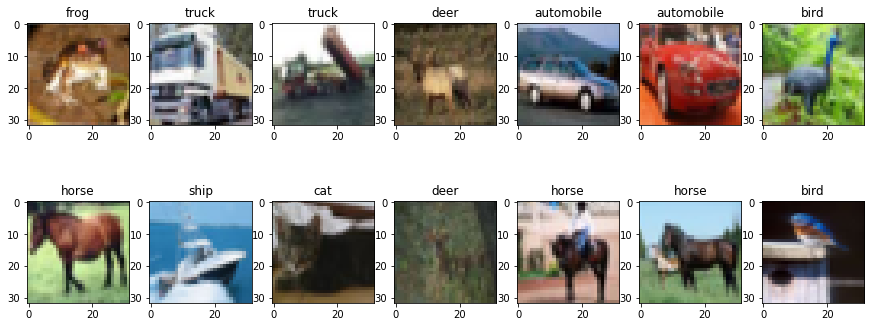

In [7]:
fig, axes = plt.subplots(2,7, figsize=(15,6))
for i, ax in enumerate(axes.reshape(-1)):
    im, label = dataset['train'][i]
    ax.imshow(im.permute(1,2,0))
    ax.set_title(class_names[label])

## Dataloaders

In [8]:
dataset.keys()

dict_keys(['train', 'val'])

In [9]:
#
def get_data_loader(batch_size):
    data_loader = { tv: torch.utils.data.DataLoader(dataset[tv], batch_size=batch_size, 
                                                    shuffle=tv=='train')
                   for tv in dataset.keys()}
    return data_loader

batch_size = 8
data_loader = get_data_loader(batch_size)

## Network Model & Loss Function

In [10]:
# A very simple model
def make_model(option=1, n_targets=10):
    in_ft = n_pixels
    
    if option == 1:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, 
                                        out_channels=out_ch, 
                                        kernel_size=kernel_size, 
                                        padding=kernel_size//2),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2),
                              nn.Conv2d(in_channels=out_ch, 
                                        out_channels=n_targets, 
                                        kernel_size=kernel_size, padding=kernel_size//2),
                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    #
    return model
#
loss_fn = nn.CrossEntropyLoss()

### sanity check

In [11]:
model = make_model()
print(model)
print('batch_size: ', data_loader['train'].batch_size)
for x, l in data_loader['train']:
    pred = model(x)
    print(pred.shape, l.shape)
    break

Sequential(
  (0): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(100, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Flatten()
)
batch_size:  8
torch.Size([8, 10]) torch.Size([8])


### Conv2d()

In [12]:
conv2d = model[0]
print(conv2d)
out = conv2d(x)
print(out.shape, x.shape)

Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
torch.Size([8, 100, 32, 32]) torch.Size([8, 3, 32, 32])


### Maxpool2d()

In [13]:
maxpool2d = nn.MaxPool2d(kernel_size=2)
mpl_out = maxpool2d(out)
print(mpl_out.shape)

torch.Size([8, 100, 16, 16])


### BatchNorm2d()
$$
    \begin{align}
        \hat x_i & = \frac{x - \mathbb{E}[x]}{\mathrm{std}(x)}  \\
        y_i & = \gamma \hat{x}_i + \beta
    \end{align}
$$
How many samples of $x$ do we have? It is the **batch_size**.

- For each channel, mean and std are estimated

In [14]:
bn2d = nn.BatchNorm2d(num_features=100)

#mpl_out.data = mpl_out.data * torch.zeros_like(mpl_out.data) + torch.full_like(mpl_out.data, 2)

bn_out = bn2d(mpl_out)
print(bn_out.shape)

print(bn2d.weight.shape, bn2d.bias.shape)

print(mpl_out[0,0,10:14,10:14])
print( bn_out[0,0,10:14,10:14])

torch.Size([8, 100, 16, 16])
torch.Size([100]) torch.Size([100])
tensor([[-0.5552, -0.5080, -0.6162, -0.7075],
        [-0.6539, -0.5550, -0.6227, -0.7107],
        [-0.6837, -0.6122, -0.6609, -0.6945],
        [-0.6493, -0.6032, -0.6870, -0.6941]], grad_fn=<SliceBackward>)
tensor([[-1.6231, -1.3873, -1.9274, -2.3834],
        [-2.1159, -1.6220, -1.9601, -2.3994],
        [-2.2644, -1.9073, -2.1505, -2.3186],
        [-2.0929, -1.8624, -2.2810, -2.3162]], grad_fn=<SliceBackward>)


---
### About CrossEntropyLoss() & Soft-Max 
- Suppose we give a data $x$ of class $k$. The model outputs 10 dimensional score vector  $s$.
- Softmax is the next procedure to be applied to the score vector to produce predicted class probabilities $q$:
$$
    \begin{align}
        q_i & = {e^{s_i}}\big/{\sum_j e^{s_j}} \\
            & = \mbox{softmax(s, label=i)}
    \end{align}
$$

- Loss function is chosen to be cross entropy, as all the other classification problems:
$$
    H(p, q) = -\sum_i p_i \log q_i
$$

- Here we have model probability $p=OneHot(k)$ which has 0s at all the locations but 1 at the $k$th location.   It does not have to be OneHot vector as a probability density model. If an input may be categorized to two objects at the same time, $p=[0,... 1/2, ..., 1/2, ... 0]$.

$$ p=OneHot(k) = [0, ... 1 ... 0] 
$$
    
- Therefore, the cross-entropy for this particular case is

$$
    \begin{align}
        H(p, q)  & =  - p_k \log q_k \\
                 & =  - \log q_k     \\
                 & =  - \log\big( {e^{s_k}}/{\sum_j e^{s_j}} \big) \\
                 & = -\bigg(s_k - \log\big(\sum_j e^{s_j}\big) \bigg)
    \end{align}
$$

- Numerical computation of this formula is much more stable than computing $\log(\exp(s_k))$ step by step.
- Given a score vector, pytorch `nn.CrossEntropyLoss()` computes this loss.
- That is, `nn.CrossEntropyLoss()` = `NLLLoss(LogSoftMax())`

* Why Cross Entropy?
    - $H(p, q)$ has a minimum value when $q$ is equal to $p$.

---
### Cross Entropy & Maximum Likelihood Estimate

- The probability mass function $q_i=P(C=i|x)$, i=0...9, of being class $i$ given an input $x$ is computed through a neural network model.
- Given this probatility mass $q=[q_i]$, what is the data likelihood?
    - In the case of Gaussian distribution modeling, the output of neural network model is the mean $\mu(x)$ and std $\sigma(x)$ given $x$. The likelihood is given by
    $$
        \begin{align}
        L & = Prob( y-delta < y < y+delta | x) \\
          & = \delta \cdot \cal{N}(x| \mu(x), \sigma(x)) \\
          & = \exp\bigg\{ -0.5 (y - \mu(x))^2 / \sigma(x)^2 \bigg\} \big/ \sqrt{2\pi}\sigma(x)
        \end{align}
    $$
    This is used for regression problems. Linear regression must be the easiest case.
    - In case of Bernoulli distribution, given a probability $p$ given by a NN model $p(x)$, the likelihood is 
    $$
        L = Prob(label = 1 | x) = p = p(x, w)
    $$
    - In cas of Multinoulli distribution, we have $C=10$ multiple candidates and $C$ discrete probabilities $p_i$, $\sum_i p_i = 1$
    
    - Since we are trying to make a model that predicts the probability, given a data $(x, k)$, $k$ being a GT label, we have a predicted probability vector $q_i = \mbox{NN}(x; w) \in \mathbb{R}^{10}$. It is an estimate of true $p_i$, The likelihood is 
    $$
        \begin{align}
            L   & = Prob(label = k | x) = q_k \\
                & = \mbox{ the $k$-th output from SoftMax() }
        \end{align}
    $$
    and we want to maximize $L$, the class probability, by modifying $w$, the parameters of NN.
    - For numerical stability mostly, we may instead maximize its logarithmic version
    $$
        l = l(w) = \log q_k(x, w)
    $$
    - The numerical package in PyTorch does only minimization. So we minimize the negative of the log-likelihood:
    $$
        \begin{align}
            NLL(w) & = -l(w) \\
                    & = -\log q_k(x, w) \\
                    & = - \log\big(\mbox{SoftMax}(s_k(x,w))\big)
        \end{align}
    $$
    

---
### Cross Entropy & Kullback-Leibler divergence
- KL Divergence
$$
    D_\mathrm{K}(p||q) = H(p,q) - H(p,p)
$$
- Cross Entropy
$$
    H(p,q) = - \sum_i p_i \log q_i
$$
- Information Entropy (Average Information)
$$
    \begin{align}
        H(p,p) = H(p) & = - \sum_i p_i \log p_i \\
        & = \sum_i p_i \log \frac{1}{p_i}
    \end{align}
$$
- Information
$$
    I(p_i) = \log\frac{1}{p_i} = I(x_i)
$$
where $x_i$ is a particular outcome of a random variable $X$.
    - Expection of $I(x_i)$ is defined to be $H(p)$ or denoted to be $H(X)$
    $$
        \mathbb{E}(I(x_i)) = H(p) = H(X)
    $$
#### References
- https://en.wikipedia.org/wiki/Entropy_(information_theory)
- https://en.wikipedia.org/wiki/Cross_entropy
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence


---
## Training Loop

In [10]:
# jupyter kernel must be initialized if the file has changed
import training_loop as tx

import importlib 
importlib.reload(tx)

<module 'training_loop' from 'D:\\git\\iadl\\class\\training_loop.py'>

## Training Setup

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1st Model

In [19]:
data_loader = get_data_loader(batch_size=1024)

model = make_model(option=1).to(device)
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(100, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Flatten()
)
32610


In [20]:
%%time
history = tx.training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)

Epoch 1, tloss 2.30 t_acc: 0.10  vloss 2.29  v_acc: 0.10
Epoch 2, tloss 2.28 t_acc: 0.11  vloss 2.28  v_acc: 0.12  (tacc: 0.10018)    
Epoch 3, tloss 2.27 t_acc: 0.13  vloss 2.26  v_acc: 0.13  (tacc: 0.10772)    
Epoch 4, tloss 2.26 t_acc: 0.15  vloss 2.25  v_acc: 0.16 (tacc: 0.13032)    
Epoch 5, tloss 2.25 t_acc: 0.17  vloss 2.24  v_acc: 0.20  (tacc: 0.15458)    
Epoch 10, tloss 2.23 t_acc: 0.20  vloss 2.22  v_acc: 0.20 (tacc: 0.17416)    
best model is loaded. finished training_loop(). 
CPU times: user 1min 30s, sys: 6.94 s, total: 1min 37s
Wall time: 1min 37s


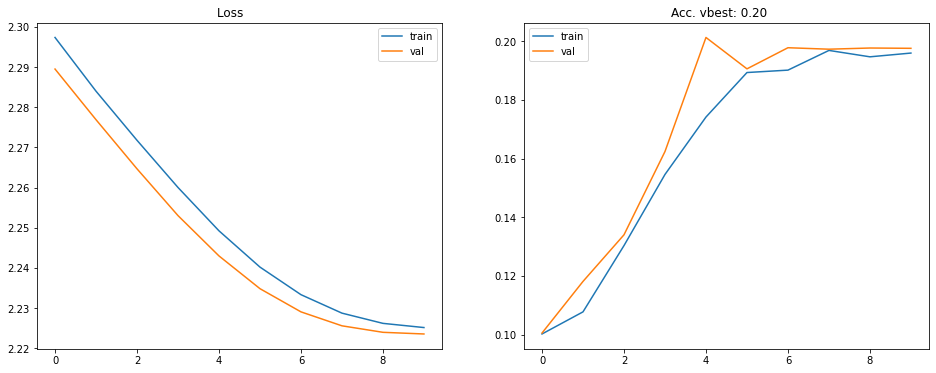

In [21]:
tx.plot_history(history)

---
### 2nd Model with Batch Normalization

In [22]:
# A very simple model
def make_model(option=1, n_targets=10):
    in_ft = n_pixels
    
    if option == 1:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2),
                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    elif option == 2:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2),
                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    #
    return model
#
loss_fn = nn.CrossEntropyLoss()

In [23]:
data_loader = get_data_loader(batch_size=1024)

model = make_model(option=2).to(device) # with batch normalization
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(100, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Flatten()
)
32810


Epoch 1, tloss 2.16 t_acc: 0.21  vloss 2.10  v_acc: 0.26
Epoch 2, tloss 2.05 t_acc: 0.26  vloss 2.02  v_acc: 0.27 (tacc: 0.21046)    
Epoch 3, tloss 2.01 t_acc: 0.28  vloss 1.99  v_acc: 0.30  (tacc: 0.25862)    
Epoch 4, tloss 1.99 t_acc: 0.30  vloss 1.96  v_acc: 0.31 (tacc: 0.28124)    
Epoch 5, tloss 1.97 t_acc: 0.31  vloss 1.95  v_acc: 0.31  (tacc: 0.29754)    
Epoch 10, tloss 1.93 t_acc: 0.32  vloss 1.92  v_acc: 0.33(tacc: 0.32198)     
best model is loaded. finished training_loop(). 4.         (tacc: 0.3232)    
CPU times: user 1min 37s, sys: 8.8 s, total: 1min 46s
Wall time: 1min 46s


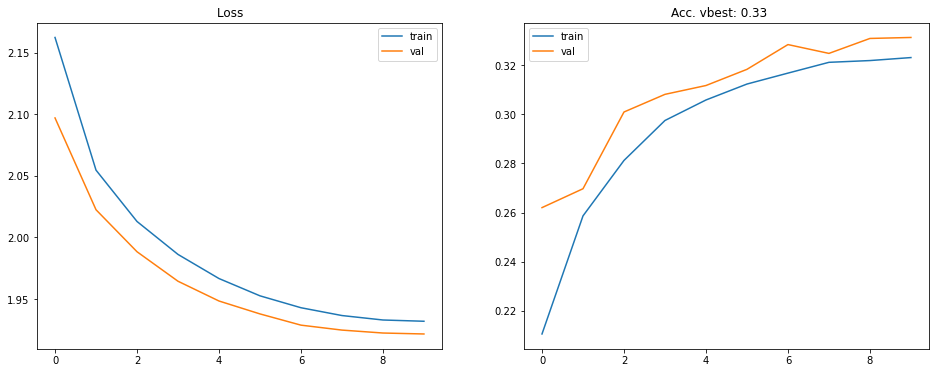

In [24]:
%%time
history = tx.training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
tx.plot_history(history)

---
### 3rd Deeper Model with Batch Normalization

In [25]:
# A very simple model
def make_model(option=1, n_targets=10):
    in_ft = n_pixels
    
    if option == 1:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2),
                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    elif option == 2:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2),
                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    elif option == 3:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2), # 32 -> 16
                              
                              nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2), # 16 -> 8

                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),

                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    #
    return model
#
loss_fn = nn.CrossEntropyLoss()

In [26]:
data_loader = get_data_loader(batch_size=1024)

model = make_model(option=3).to(device) # with batch normalization
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(100, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Flatten()
)
283110


Epoch 1, tloss 2.03 t_acc: 0.27  vloss 1.95  v_acc: 0.28
Epoch 2, tloss 1.83 t_acc: 0.35  vloss 1.76  v_acc: 0.37  (tacc: 0.27492)    
Epoch 3, tloss 1.72 t_acc: 0.39  vloss 1.68  v_acc: 0.40  (tacc: 0.3491)    
Epoch 4, tloss 1.65 t_acc: 0.41  vloss 1.61  v_acc: 0.42  (tacc: 0.3862)    
Epoch 5, tloss 1.60 t_acc: 0.43  vloss 1.63  v_acc: 0.41 (tacc: 0.41292)    
Epoch 10, tloss 1.51 t_acc: 0.47  vloss 1.50  v_acc: 0.47 (tacc: 0.46668)    
best model is loaded. finished training_loop(). 5.         (tacc: 0.4672)    
CPU times: user 1min 55s, sys: 14 s, total: 2min 9s
Wall time: 2min 9s


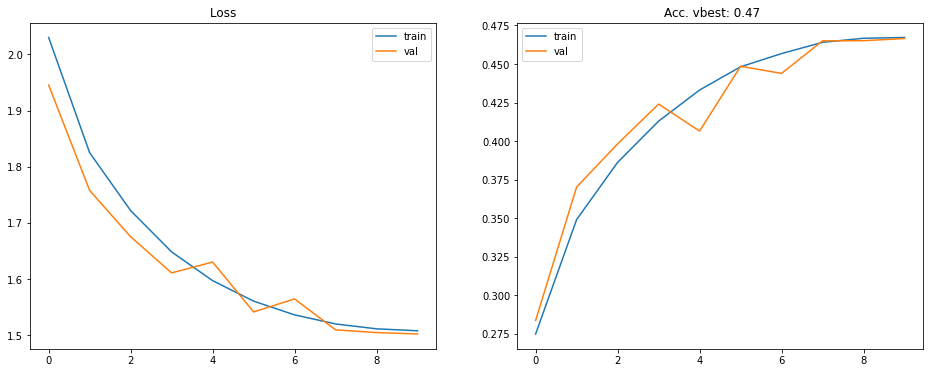

In [27]:
%%time
history = tx.training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
tx.plot_history(history)

### Deeper and Deeper

In [16]:
# A very simple model
def make_model(option=1, n_targets=10):
    in_ft = n_pixels
    
    if option == 1:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2),
                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    elif option == 2:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2),
                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    elif option == 3:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2), # 32 -> 16
                              
                              nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2), # 16 -> 8

                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),

                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1]
                              nn.Flatten() # [B, 2]
                             )
    elif option == 4:
        kernel_size = 5
        out_ch = 100
        model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2), # size reduction 1/2, 32->16

                              nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),

                              nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2), # size reduction 1/2; 16 -> 8

                              nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2), # size reduction 1/2; 8 -> 4

                              nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=kernel_size, padding=kernel_size//2),
                              nn.BatchNorm2d(num_features=out_ch), # Batch Normalization
                              nn.ReLU(),

                              nn.Conv2d(in_channels=out_ch, out_channels=n_targets, kernel_size=kernel_size, padding=kernel_size//2),

                              nn.AdaptiveAvgPool2d(output_size=1), # [B, 2, 1, 1];
                              nn.Flatten() # [B, 2]
                             )
    #
    return model
#
loss_fn = nn.CrossEntropyLoss()

In [29]:
data_loader = get_data_loader(batch_size=1024)

model = make_model(option=4).to(device) # with batch normalization
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (8): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (12): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(100, 100, kernel

Epoch 1, tloss 2.05 t_acc: 0.29  vloss 1.96  v_acc: 0.30
Epoch 2, tloss 1.72 t_acc: 0.39  vloss 1.75  v_acc: 0.37  (tacc: 0.28868)    
Epoch 3, tloss 1.55 t_acc: 0.44  vloss 1.61  v_acc: 0.43  (tacc: 0.39068)    
Epoch 4, tloss 1.44 t_acc: 0.48  vloss 1.42  v_acc: 0.49  (tacc: 0.44432)    
Epoch 5, tloss 1.34 t_acc: 0.52  vloss 1.49  v_acc: 0.47  (tacc: 0.48432)    
Epoch 10, tloss 1.16 t_acc: 0.59  vloss 1.17  v_acc: 0.59 (tacc: 0.59008)    
best model is loaded. finished training_loop(). .         (tacc: 0.59384)    
CPU times: user 2min 31s, sys: 24.2 s, total: 2min 56s
Wall time: 2min 55s


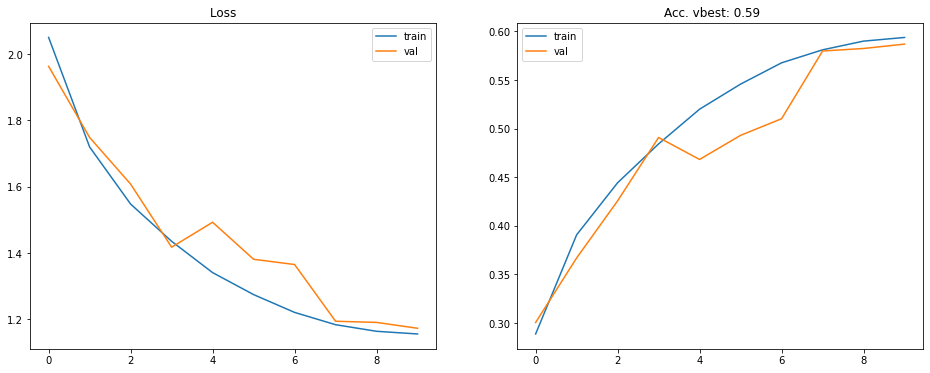

In [30]:
%%time
history = tx.training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
tx.plot_history(history)

### Deeper and Deeper with Smaller batch_size
- SGD: Stochastic Gradient Descient

In [31]:
data_loader = get_data_loader(batch_size=128)

model = make_model(option=4).to(device) # with batch normalization
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

Sequential(
  (0): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (8): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (12): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(100, 100, kernel

Epoch 1, tloss 1.54 t_acc: 0.44  vloss 2.19  v_acc: 0.30
Epoch 2, tloss 1.10 t_acc: 0.61  vloss 2.18  v_acc: 0.33  (tacc: 0.44176)    
Epoch 3, tloss 0.90 t_acc: 0.68  vloss 0.91  v_acc: 0.68  (tacc: 0.60518)    
Epoch 4, tloss 0.76 t_acc: 0.73  vloss 1.34  v_acc: 0.55  (tacc: 0.6828)    
Epoch 5, tloss 0.65 t_acc: 0.78  vloss 0.91  v_acc: 0.69
Epoch 10, tloss 0.30 t_acc: 0.91  vloss 0.60  v_acc: 0.79 (tacc: 0.9018)     
best model is loaded. finished training_loop(). 9.         (tacc: 0.91322)    
CPU times: user 3min 4s, sys: 26 s, total: 3min 30s
Wall time: 3min 30s


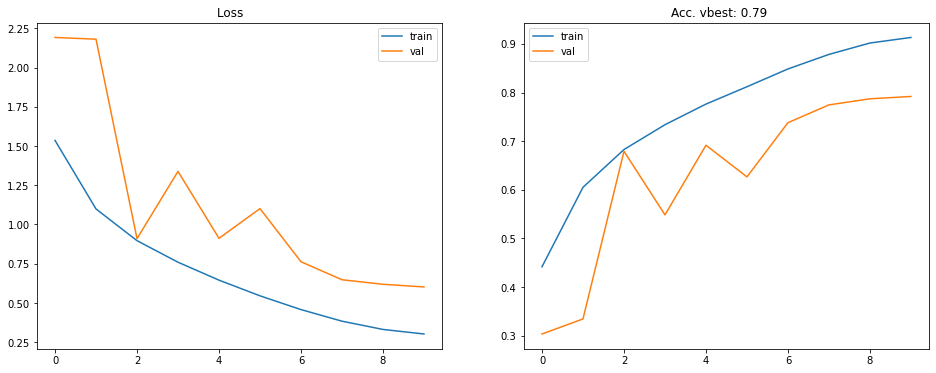

In [32]:
%%time
history = tx.training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
tx.plot_history(history)

## Practicum

Now it is your turn to go on. How far can you reach? Try and report during next meeting.

- Tuning hyper-parameters is important.
- Deeper network seems better.
- data normalization/standardization is always good.

---

## Theory: Batch Normalization
- Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, Sergey Ioffe, Christian Szegedy, 2015
- https://en.wikipedia.org/wiki/Batch_normalization
- [PR-021: Batch Normalization](https://www.youtube.com/watch?v=TDx8iZHwFtM) video tutorial

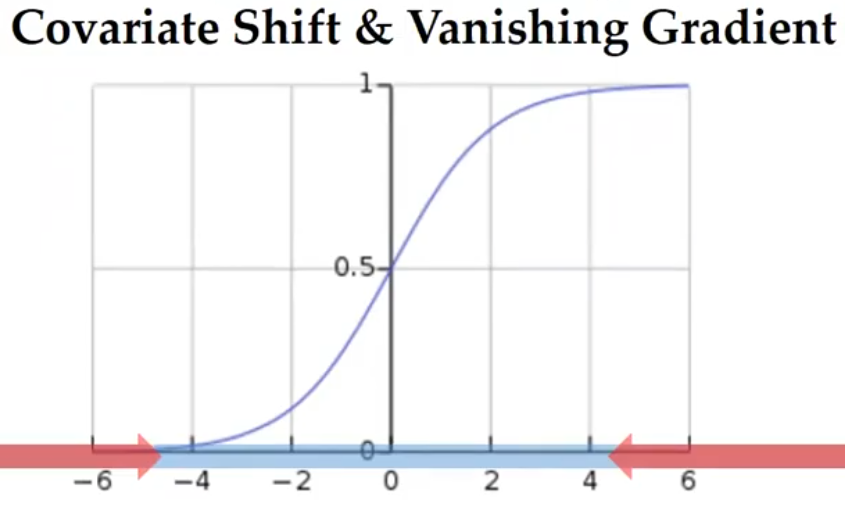

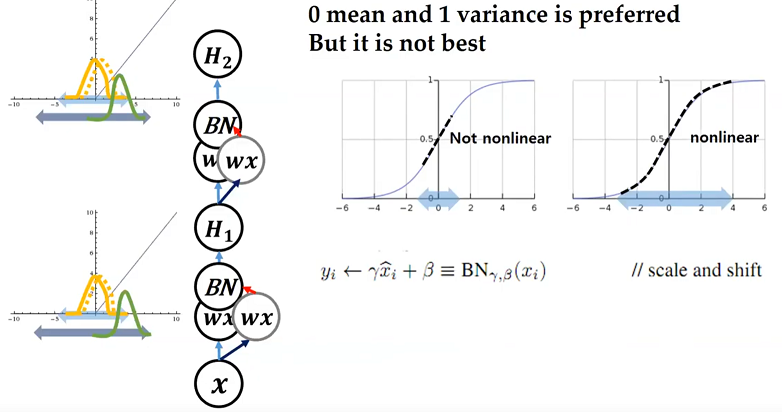

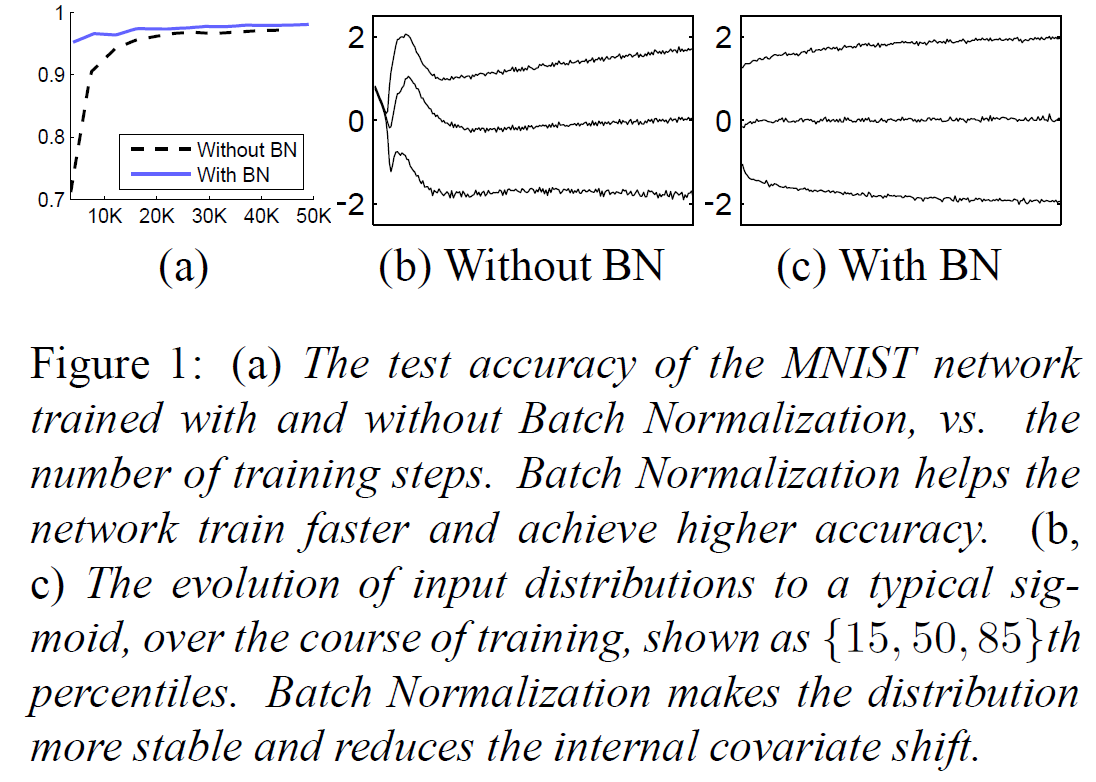

---

End.

---
### ResNet, Just try

In [33]:
data_loader = get_data_loader(batch_size=128)

import torchvision

model = torchvision.models.resnet18(pretrained=False).to(device) # with batch normalization
print(model)
print(count_params(model))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

history = None

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1, tloss 1.78 t_acc: 0.40  vloss 1.50  v_acc: 0.46
Epoch 2, tloss 1.30 t_acc: 0.53  vloss 1.35  v_acc: 0.52  (tacc: 0.40054)    
Epoch 3, tloss 1.13 t_acc: 0.59  vloss 1.38  v_acc: 0.52  (tacc: 0.52934)    
Epoch 4, tloss 0.97 t_acc: 0.65  vloss 1.40  v_acc: 0.53
Epoch 5, tloss 0.83 t_acc: 0.71  vloss 1.30  v_acc: 0.56  (tacc: 0.6541)    
Epoch 10, tloss 0.35 t_acc: 0.90  vloss 1.22  v_acc: 0.61 (tacc: 0.88644)    
best model is loaded. finished training_loop(). 3.         (tacc: 0.90174)    
CPU times: user 3min 27s, sys: 29.4 s, total: 3min 56s
Wall time: 3min 56s


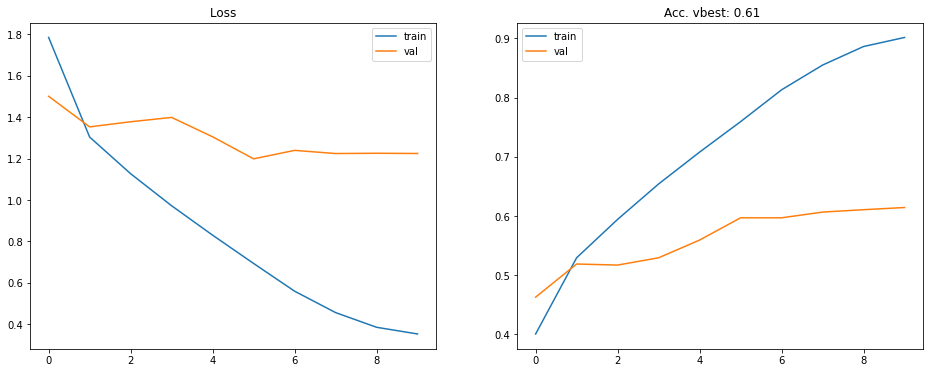

In [34]:
%%time
history = tx.training_loop(10, 
                        optimizer, model, criterion, 
                        data_loader['train'], data_loader['val'], 
                        hist=history,
                        lr_scheduler=lr_scheduler,
                        device=device)
tx.plot_history(history)

---

## CIFAR10 Learning Models and Results

- https://github.com/kuangliu/pytorch-cifar
- https://github.com/bearpaw/pytorch-classification

---
End.